In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import japanize_matplotlib
from causalnex.structure.notears import from_pandas
from sklearn.preprocessing import StandardScaler

In [4]:
def processing_df(df):
    df.drop(["Unnamed: 0","year", "area", "code", "総人口"], axis=1, inplace=True)
    df.replace("-", 0, inplace=True)
        
def calc_changing_rate(df_prev, df):
    df_cr = (df - df_prev + 0.01) / (df_prev + 0.01)
    return df_cr

def scaler(x):
    return (2 / (1 + math.exp(-2*x))) - 1

def structure_learning(df, threshold=None, max_iter=None):
    input_tr = df.applymap(scaler)
    return from_pandas(input_tr, w_threshold=threshold, max_iter=max_iter)

def make_color_list(dag, target_node):
    if target_node not in dag.nodes:
        raise ValueError(f"target_node {target_node} is not in the graph")
    
    incoming_edges = dag.in_edges(target_node)
    parent_nodes = [edge[0] for edge in incoming_edges]
    print(f"parent_nodes: {parent_nodes}")

    incoming_edges_grandparent = dag.in_edges(parent_nodes)
    grandparent_nodes = [edge[0] for edge in incoming_edges_grandparent]
    print(f"grandparent_nodes: {grandparent_nodes}")
    
    node_color = []
    edge_color = []
    
    for node in dag.nodes:
        if node == target_node:
            node_color.append("red")
        elif node in parent_nodes:
            node_color.append("blue")
        elif node in grandparent_nodes:
            node_color.append("lightgreen")
        else:
            node_color.append("gray")

    # for node in dag.nodes:
    #     if node == target_node:
    #         node_color.append("red")
    #     elif node in parent_nodes:
    #         node_color.append("blue")
    #     else:
    #         node_color.append("gray")
            
    for edge in dag.edges:
        if edge in incoming_edges:
            edge_color.append("blue")
        elif edge in incoming_edges_grandparent:
            edge_color.append("lightgreen")
        else:
            edge_color.append("black")
            
    return node_color, edge_color
    

def plot_struct(dag, node_color, edge_color, title, figsize=(15, 15)):
    pos = nx.circular_layout(dag)
    red_patch = mpatches.Patch(color="red", label="若年人口")
    blue_patch = mpatches.Patch(color="blue", label="親ノード")
    green_patch = mpatches.Patch(color="lightgreen", label="親ノード以外の祖先のノード")
    gray_patch = mpatches.Patch(color="gray", label="その他ノード")

    plt.figure(figsize=figsize)
    nx.draw(dag, pos=pos, with_labels=True, node_color=node_color, edge_color=edge_color,font_family="Osaka")
    # nx.draw_networkx_labels(dag, pos=pos, labels=labels, font_family="Osaka")
    plt.title(title)
    plt.legend(handles=[red_patch, blue_patch, green_patch, gray_patch], loc="upper left")
    plt.show()

In [5]:
# 年度ごとのデータ
df00 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2000")
df05 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2005")
df10 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2010")
df15 = pd.read_excel("/Users/itsukikuwahara/Desktop/codes/research/data/data1.xlsx", sheet_name="2015")

In [6]:
# 不要な列を削除
processing_df(df00)
processing_df(df05)
processing_df(df10)
processing_df(df15)

# 必要な増減率を計算
df00_05 = calc_changing_rate(df00, df05)
df05_10 = calc_changing_rate(df05, df10)
df10_15 = calc_changing_rate(df10, df15)

In [7]:
# データを結合して、全体のデータフレームを作成
all_df = pd.concat([df00_05, df05_10, df10_15], axis=0)
all_df.dropna(inplace=True)
all_df.reset_index(drop=True, inplace=True)

In [8]:
sl = structure_learning(all_df, threshold=0.2, max_iter=1000)

parent_nodes: ['一般診療所数/10万人', '一般診療所数/可住地面積', '自市区町村で従業・通学している人口']
grandparent_nodes: ['第三次産業就業者', '一般診療所数/可住地面積', '昼夜間人口比率(%)', '第三次産業就業者', '耕地面積【ｈａ】', '第三次産業就業者', '一般診療所数/10万人', '一般診療所数/可住地面積', '耕地面積【ｈａ】']


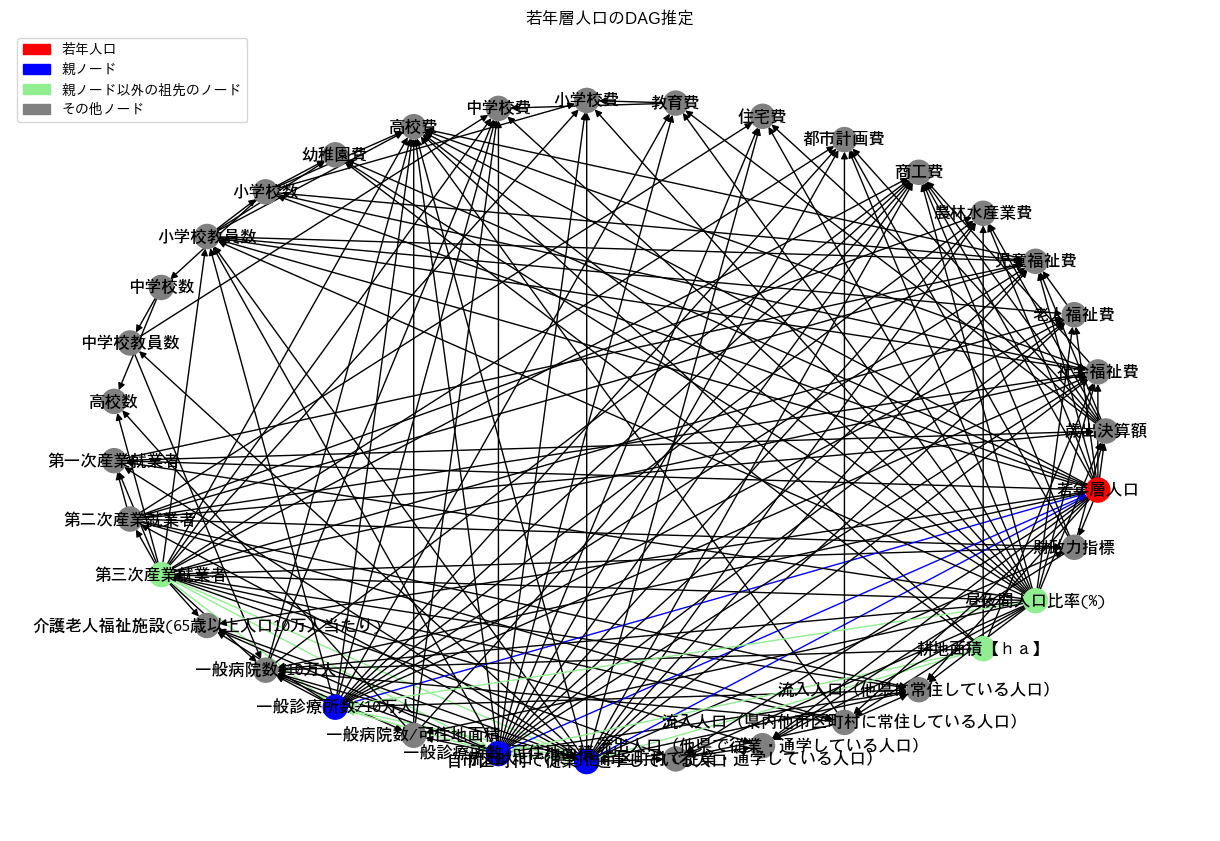

In [9]:
node_color, edge_color = make_color_list(sl, target_node="若年層人口")
plot_struct(sl, node_color, edge_color, title="若年層人口のDAG推定",figsize=(12, 8))

### 論文用のDAG

In [132]:
def plot_specific_node(dag, target_node, title, figsize=(12,8)):
    incoming_edges = dag.in_edges(target_node)
    parent_nodes = [edge[0] for edge in incoming_edges]

    parent_incoming_edges = dag.in_edges(parent_nodes)
    ancestor_nodes = [edge[0] for edge in parent_incoming_edges]

    print(f"ancestor_nodes: {ancestor_nodes}")
    
    plot_nodes = ancestor_nodes + parent_nodes + [target_node]

    sub_dag = dag.subgraph(plot_nodes)
    pos_paper = nx.spring_layout(sub_dag)

    plt.figure(figsize=figsize)    
    nx.draw(
        sub_dag,
        pos=pos_paper,
        with_labels=True,
        font_family="Osaka",
        font_size=20
    )
    # plt.title(title, fontsize=20)
    # plt.subplots_adjust(left=0.05, right=10, top=0.5, bottom=0.2)
    plt.show()

ancestor_nodes: ['第三次産業就業者', '一般診療所数/可住地面積', '昼夜間人口比率(%)', '第三次産業就業者', '耕地面積【ｈａ】', '第三次産業就業者', '一般診療所数/10万人', '一般診療所数/可住地面積', '耕地面積【ｈａ】']


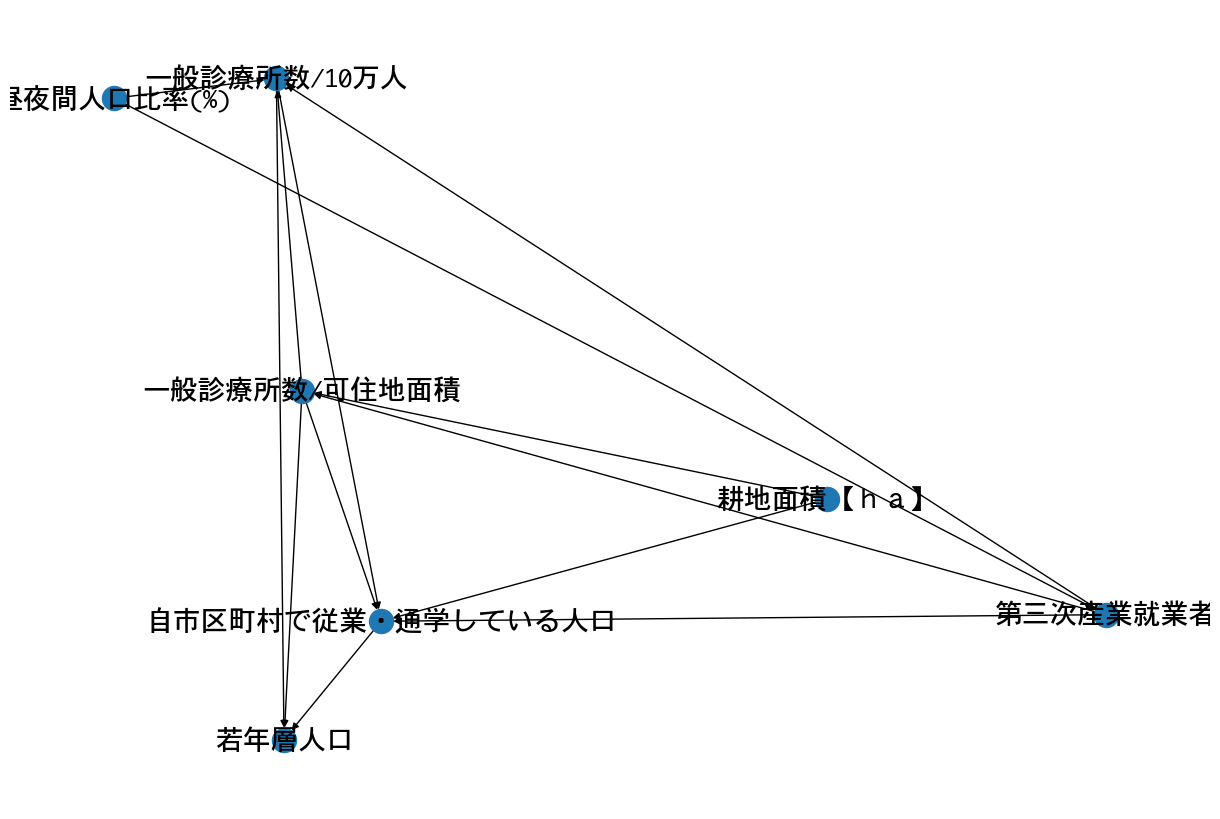

In [133]:
plot_specific_node(sl, target_node="若年層人口", title="若年層人口の祖先ノードのDAG推定")